## Twitter Sentiment Analysis: Apple vs. Google

### Problem Statement
In today's digital age, customer opinions on tech products are widely shared on social media platforms like Twitter. Understanding public sentiment towards brands like Apple and Google is crucial for businesses to assess customer satisfaction, improve marketing strategies, and address potential issues. 

This project aims to develop a Natural Language Processing (NLP) model that can automatically classify the sentiment of tweets about Apple and Google products as positive, negative, or neutral. By analyzing real-world social media data, this model will help derive valuable insights into consumer perceptions.

### Dataset Description
The dataset comes from CrowdFlower via data.world. It contains over 9,000 tweets about Apple and Google products, rated by human annotators as positive, negative, or neutral. The goal of this project is to build an NLP model to classify the sentiment of tweets based on their content.

### Project Overview
This project aims to:
- Preprocess and analyze the dataset.
- Build a binary classifier (positive vs. negative) as a proof of concept.
- Extend to a multiclass classifier by including neutral tweets.
- Evaluate different NLP models (Logistic Regression, LSTM, BERT).
- Interpret model results using SHAP.

### Import Necessary Libraries
To perform data analysis, visualization, and model training, we need to import essential Python libraries.

In [70]:
# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# Download NLTK Resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data Understanding

#### Understanding the dataset
Before building our NLP model, we first examine the dataset structure, identify missing values, and analyze sentiment label distributions.

### Dataset Description
The dataset consists of 8,721 tweets with three columns:
- `tweet_text`: The text of the tweet.
- `emotion_in_tweet_is_directed_at`: The entity (if any) at which the emotion is directed (Apple, Google, etc.), with 5,552 missing values.
- `is_there_an_emotion_directed_at_a_brand_or_product`: Indicates whether an emotion is directed at a brand or product.

The dataset is entirely text-based, requiring preprocessing to handle missing values and prepare it for sentiment analysis.

In [46]:
# Load dataset
df = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')  # Update with actual file path
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [47]:
# Display dataset information
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


None

In [48]:
# Check for missing values
display(df.isnull().sum())

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5552
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [49]:
# Display column names and data types
display(df.dtypes)

tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object

### 1. Exploratory Data Analysis (EDA)
EDA helps in visualizing sentiment distribution and identifying trends in the data.

#### Handling Missing Values
Handling missing values ensures data consistency and reliability before applying NLP models.

- The `emotion_in_tweet_is_directed_at` column has **5,552 missing values**, which are replaced with `"Unknown"` to retain data while acknowledging the uncertainty.
- The `tweet_text` column is critical for sentiment analysis, so rows where this field is missing are **dropped**.
- Other columns are analyzed, but no additional significant missing values require handling.

This step ensures that the dataset remains robust for sentiment classification while minimizing data loss.


In [50]:
# Handle missing values
df['emotion_in_tweet_is_directed_at'].fillna('Unknown', inplace=True)
df.dropna(subset=['tweet_text'], inplace=True)  # Dropping tweets with no text

C:\Users\USER\AppData\Local\Temp\ipykernel_16344\1543978109.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['emotion_in_tweet_is_directed_at'].fillna('Unknown', inplace=True)


#### Renaming Sentiment Column for Clarity
The sentiment column name is long and unclear. We rename it to "sentiment" for simplicity.

In [51]:
# Rename column and sentiment categories
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)
df['sentiment'] = df['sentiment'].replace({'No emotion toward brand or product': 'No emotion'})

C:\Users\USER\AppData\Local\Temp\ipykernel_16344\4280915105.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


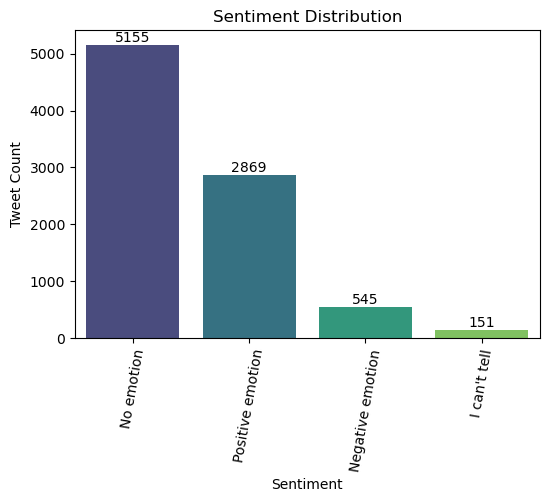

In [52]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6,4))
plt.xticks(rotation=80)
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 50, str(v), ha='center')
plt.show()

#### Sentiment Distribution Analysis  
The sentiment distribution graph displays the frequency of different sentiment categories in the dataset. The key observations are:  

- **"No emotion"** is the most frequent category, with over **5,000 tweets**, indicating that a majority of users express neutral or unrelated opinions.  
- **"Positive emotion"** is the second most common, with close to **3,000 tweets**, suggesting a significant number of favorable sentiments toward the brands.  
- **"Negative emotion"** is the least common, with a little more than **500 tweets**, showing that negative feedback is relatively low.  
- A small number of tweets fall under the **"I can't tell"** category, implying uncertainty in sentiment expression.  

This distribution suggests that while many tweets do not explicitly express sentiment toward a brand, when emotions are present, positive sentiments outweigh negative ones.

### Tokenization
Tokenization is a crucial step in NLP, where text is split into individual words (tokens). This helps in:
- Standardizing text representation
- Removing unnecessary punctuation
- Enabling further preprocessing like stopword removal and lemmatization 

Tokenizing before word frequency analysis ensures that we capture meaningful words rather than raw text.

In [72]:
# Define text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase for standardization
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text)  # Tokenize text into words
    stopwords_list = set(stopwords.words('english'))  # Load stopwords
    
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word not in stopwords_list and word.isalpha()]
    
    # Apply lemmatization for better text normalization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Apply stemming as an additional normalization step
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = [word for word in tokens if len(word) > 2]  # Remove rare words
    
    return tokens

In [73]:
# Apply preprocessing
df['preprocessed_text'] = df['tweet_text'].apply(preprocess_text)

#### Frequent Words by Sentiment Category
We will visualize the top 10 most common words per sentiment category.

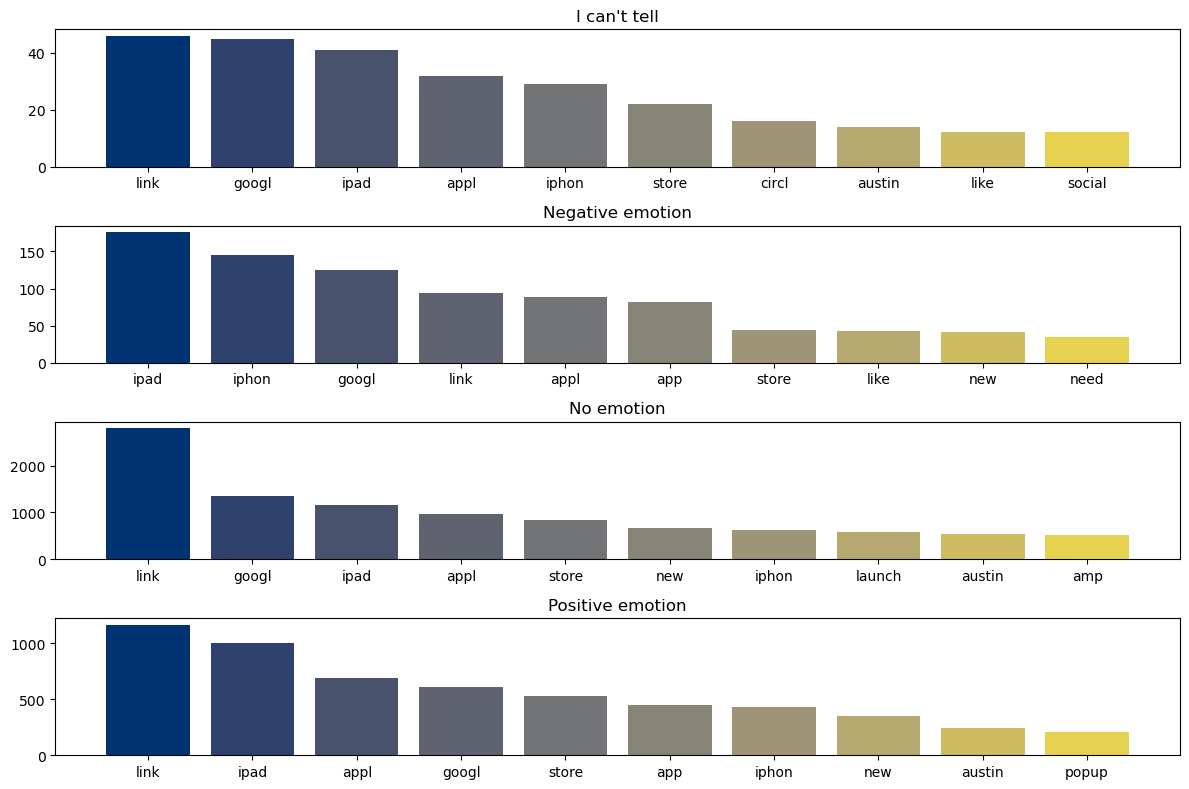

In [74]:
fig, axes = plt.subplots(nrows=len(df['sentiment'].unique()), figsize=(12, 2 * len(df['sentiment'].unique())))
for idx, (sentiment, sentiment_df) in enumerate(df.groupby('sentiment')):
    all_words = [word for text in sentiment_df['preprocessed_text'] for word in text]
    top_10 = pd.Series(all_words).value_counts()[:10]
    axes[idx].bar(top_10.index, top_10.values, color=sns.color_palette('cividis', n_colors=10))
    axes[idx].set_title(sentiment)
fig.tight_layout()
plt.show()


### Hashtag & Mention Analysis
In this section, we will find the most used hashtags and mentions

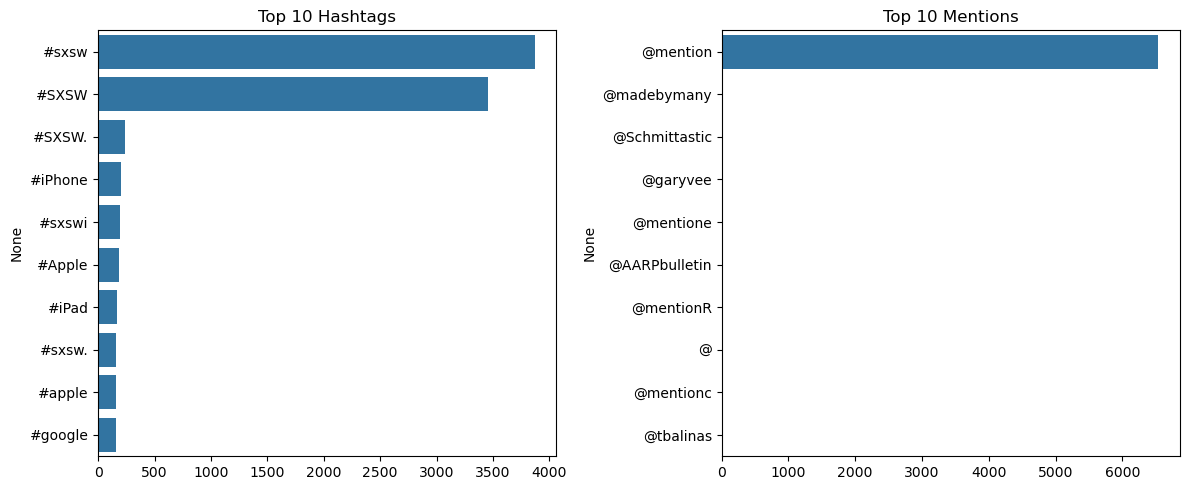

In [78]:
import itertools

# Extract hashtags and mentions
df['hashtags'] = df['tweet_text'].apply(lambda x: [word for word in x.split() if word.startswith('#')])
df['mentions'] = df['tweet_text'].apply(lambda x: [word for word in x.split() if word.startswith('@')])

# Flatten lists
all_hashtags = list(itertools.chain(*df['hashtags']))
all_mentions = list(itertools.chain(*df['mentions']))

# Get top 10 hashtags & mentions
top_hashtags = pd.Series(all_hashtags).value_counts()[:10]
top_mentions = pd.Series(all_mentions).value_counts()[:10]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=top_hashtags.values, y=top_hashtags.index, ax=axes[0])
axes[0].set_title('Top 10 Hashtags')

sns.barplot(x=top_mentions.values, y=top_mentions.index, ax=axes[1])
axes[1].set_title('Top 10 Mentions')

plt.tight_layout()
plt.show()


### Bigram & Trigram Analysis
Finds the most frequent word pairs and triplets.

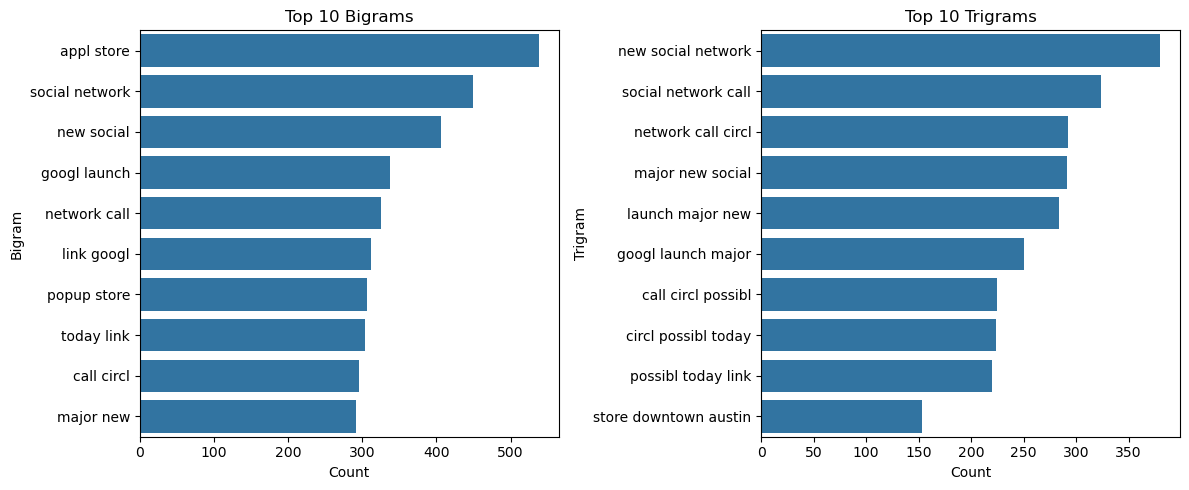

In [77]:
from collections import Counter
from itertools import islice
from nltk.util import ngrams

# Function to extract n-grams
def get_top_ngrams(corpus, n=2, top_k=10):
    tokens = [word for text in corpus for word in text]  # Flatten list
    n_grams = list(ngrams(tokens, n))
    return Counter(n_grams).most_common(top_k)

# Compute top bigrams and trigrams
bigrams = get_top_ngrams(df['preprocessed_text'], n=2, top_k=10)
trigrams = get_top_ngrams(df['preprocessed_text'], n=3, top_k=10)

# Convert to DataFrame for plotting
bigram_df = pd.DataFrame(bigrams, columns=['Bigram', 'Count'])
trigram_df = pd.DataFrame(trigrams, columns=['Trigram', 'Count'])

# Plot bigrams & trigrams
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(y=bigram_df['Bigram'].apply(lambda x: ' '.join(x)), x=bigram_df['Count'], ax=axes[0])
axes[0].set_title('Top 10 Bigrams')

sns.barplot(y=trigram_df['Trigram'].apply(lambda x: ' '.join(x)), x=trigram_df['Count'], ax=axes[1])
axes[1].set_title('Top 10 Trigrams')

plt.tight_layout()
plt.show()
